<a href="https://colab.research.google.com/github/slisovych/machine_learning_hometasks/blob/main/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any

In [ ]:
raw_df = pd.read_csv('train.csv')

In [ ]:
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [ ]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [ ]:
target_col = 'Exited'
input_cols = [col for col in raw_df.columns if col not in ['Exited', 'CustomerId', 'Surname']]

# 1. Розділення на train/val
train_df, val_df = split_train_val(raw_df, target_col=target_col)

# 2. Розділення на X/y
X_train, y_train = separate_inputs_targets(train_df, input_cols=input_cols, target_col=target_col)
X_val, y_val = separate_inputs_targets(val_df, input_cols=input_cols, target_col=target_col)

# Повернемо форми отриманих даних
X_train.shape, y_train.shape, X_val.shape, y_val.shape


((12000, 11), (12000,), (3000, 11), (3000,))

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [ ]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')

In [ ]:
X_train.dtypes

,0
id,int64
CreditScore,float64
Geography,category
Gender,category
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score

xgb_clf = XGBClassifier(
    max_depth=5,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    #use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train, y_train)

train_pred = xgb_clf.predict(X_train)
val_pred = xgb_clf.predict(X_val)

# Оцінка моделі за AUC ROC
train_preds_proba = xgb_clf.predict_proba(X_train)[:, 1]
val_preds_proba = xgb_clf.predict_proba(X_val)[:, 1]
train_auc = roc_auc_score(y_train, train_preds_proba)
val_auc = roc_auc_score(y_val, val_preds_proba)

print(f"Train ROC-AUC: {train_auc:.4f}, Validation ROC-AUC: {val_auc:.4f}")
print(classification_report(y_train, train_pred, digits=4))
print(classification_report(y_val, val_pred, digits=4))

Train ROC-AUC: 0.9442, Validation ROC-AUC: 0.9345
              precision    recall  f1-score   support

         0.0     0.9251    0.9645    0.9444      9558
         1.0     0.8334    0.6945    0.7577      2442

    accuracy                         0.9096     12000
   macro avg     0.8793    0.8295    0.8510     12000
weighted avg     0.9065    0.9096    0.9064     12000

              precision    recall  f1-score   support

         0.0     0.9193    0.9531    0.9359      2390
         1.0     0.7854    0.6721    0.7244       610

    accuracy                         0.8960      3000
   macro avg     0.8524    0.8126    0.8301      3000
weighted avg     0.8921    0.8960    0.8929      3000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:28] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:28] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train ROC-AUC: 0.9446

Validation ROC-AUC: 0.9350

Високі значення, і різниця між train/val невелика (≈0.01), що свідчить про не сильне high variance.

Результати по DecisionTrees (попередні):

Train ROC-AUC: 0.9287

Validation ROC-AUC: 0.9225

Отже, модель XGBoost покращила якість.



3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [ ]:
!pip install hyperopt

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        # use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=20
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
    pred = clf.predict(X_val)

    val_preds_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds_proba)

    return {'loss': -val_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, y_train)
final_pred = final_clf.predict(X_val)
final_train_preds_proba = final_clf.predict_proba(X_train)[:, 1]
final_val_preds_proba = final_clf.predict_proba(X_val)[:, 1]
final_train_auc = roc_auc_score(y_train, final_train_preds_proba)
final_val_auc = roc_auc_score(y_val, final_val_preds_proba)

print(f"Final Train ROC-AUC: {final_train_auc:.4f}, Final Validation ROC-AUC: {final_val_auc:.4f}")
print(classification_report(y_val, final_pred, digits=4))


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:35] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:35] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:05<01:46,  5.63s/trial, best loss: -0.9316208244735579]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:16<02:33,  8.52s/trial, best loss: -0.935999039714658] 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:19<01:45,  6.19s/trial, best loss: -0.935999039714658]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:25<00:59,  3.98s/trial, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:00] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:00] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:26<00:38,  2.77s/trial, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:28<00:33,  2.56s/trial, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:28<00:22,  1.91s/trial, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:29<00:15,  1.42s/trial, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:29<00:10,  1.07s/trial, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:04] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:04] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:29<00:07,  1.17trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:30<00:05,  1.41trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:05] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:05] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:30<00:04,  1.47trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:06] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:06] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:32<00:03,  1.26trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:33<00:02,  1.62trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 90%|█████████ | 18/20 [00:33<00:00,  2.15trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:34<00:00,  2.38trial/s, best loss: -0.9366005898895672]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:34<00:00,  1.73s/trial, best loss: -0.9366005898895672]
Найкращі гіперпараметри:  {'colsample_bytree': np.float64(0.6754093811451578), 'gamma': np.float64(0.22043744921815323), 'learning_rate': np.float64(0.034531666561108156), 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 250, 'reg_alpha': np.float64(0.3460024860779801), 'reg_lambda': np.float64(0.840946829361546), 'subsample': np.float64(0.5218492006541864)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:25:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Train ROC-AUC: 0.9517, Final Validation ROC-AUC: 0.9352
              precision    recall  f1-score   support

         0.0     0.9224    0.9544    0.9381      2390
         1.0     0.7932    0.6852    0.7353       610

    accuracy                         0.8997      3000
   macro avg     0.8578    0.8198    0.8367      3000
weighted avg     0.8961    0.8997    0.8969      3000



Train ROC-AUC: 0.9548

Validation ROC-AUC: 0.9365

Отже, модель XGBoost з тюнінгом параметрів покращила якість.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [ ]:
# %%bash
# sudo apt-get update
# sudo apt-get install -y build-essential cmake git wget unzip
# sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
# sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
# sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
# sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
# sudo apt-get install -y python3-pip

In [ ]:
# %%bash
# sudo apt-get install -y ocl-icd-libopencl1 clinfo
# sudo apt-get install -y nvidia-opencl-dev opencl-headers

In [ ]:
# %%bash
# git clone --recursive https://github.com/microsoft/LightGBM
# cd LightGBM
# mkdir build
# cd build
# cmake -DUSE_CUDAP=1 ..
# make -j4

In [ ]:
# %%bash
# cd ..
# python setup.py install

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


In [ ]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,# явне вказування пропущених значень
    metric='auc',
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

train_pred = lgb_clf.predict(X_train)
val_pred = lgb_clf.predict(X_val)

# Оцінка моделі за AUC ROC
train_preds_proba = lgb_clf.predict_proba(X_train)[:, 1]
val_preds_proba = lgb_clf.predict_proba(X_val)[:, 1]
train_auc = roc_auc_score(y_train, train_preds_proba)
val_auc = roc_auc_score(y_val, val_preds_proba)

print(f"Train ROC-AUC: {train_auc:.4f}, Validation ROC-AUC: {val_auc:.4f}")

print(classification_report(y_train, train_pred, digits=4))
print(classification_report(y_val, val_pred, digits=4))

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,3, categorical_column=2,3 will be ignored. Current value: categorical_feature=2,3
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

Train ROC-AUC: 0.9391

Validation ROC-AUC: 0.9363

Високі значення, і різниця між train/val невелика (≈0.001), що свідчить про можливе незначне high variance.

Ркзультати по XGBoost:

Train ROC-AUC: 0.9548

Validation ROC-AUC: 0.9365

Отже, модель XGBoost з тюнінгом параметрів має кращу якість.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes,  # Індекси категорійних ознак
        metric='auc',
        missing=np.nan,
        early_stopping_rounds=10
    )

    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    pred = clf.predict(X_val)

    val_preds_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds_proba)

    return {'loss': -val_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan,
    metric='auc'
)

final_lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
final_lgb_pred = final_lgb_clf.predict(X_val)
final_lgb_train_preds_proba = final_lgb_clf.predict_proba(X_train)[:, 1]
final_lgb_val_preds_proba = final_lgb_clf.predict_proba(X_val)[:, 1]
final_train_auc = roc_auc_score(y_train, final_lgb_train_preds_proba)
final_val_auc = roc_auc_score(y_val, final_lgb_val_preds_proba)

print(f"Final LGB Train ROC-AUC: {final_train_auc:.4f}, Final LGB Validation ROC-AUC: {final_val_auc:.4f}")

print(classification_report(y_val, final_lgb_pred, digits=4))


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] categorical_feature is set with cat_feature=2,3, categorical_column=2,3 will be ignored. Current value: categorical_feature=2,3
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info]

Train ROC-AUC: 0.9537

Validation ROC-AUC: 0.9346

Високі значення, є різниця між train/val, що свідчить про можливе high variance.

Ркзультати по XGBoost:

Train ROC-AUC: 0.9548

Validation ROC-AUC: 0.9365

Отже, модель XGBoost з тюнінгом параметрів має кращу якість.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [ ]:
test_df = pd.read_csv('test.csv')

X_test = test_df[input_cols].copy()

X_test[cat_features] = X_test[cat_features].astype('category')

test_predictions = final_clf.predict(X_test)

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['Exited'] = test_predictions

In [ ]:
submission.to_csv('submission_XGBoost.csv', index=False)

In [ ]:
test_lgb_predictions = final_lgb_clf.predict(X_test)

submission['Exited'] = test_lgb_predictions

submission.to_csv('submission_LGB.csv', index=False)

[LightGBM] [Warning] Unknown parameter: missing


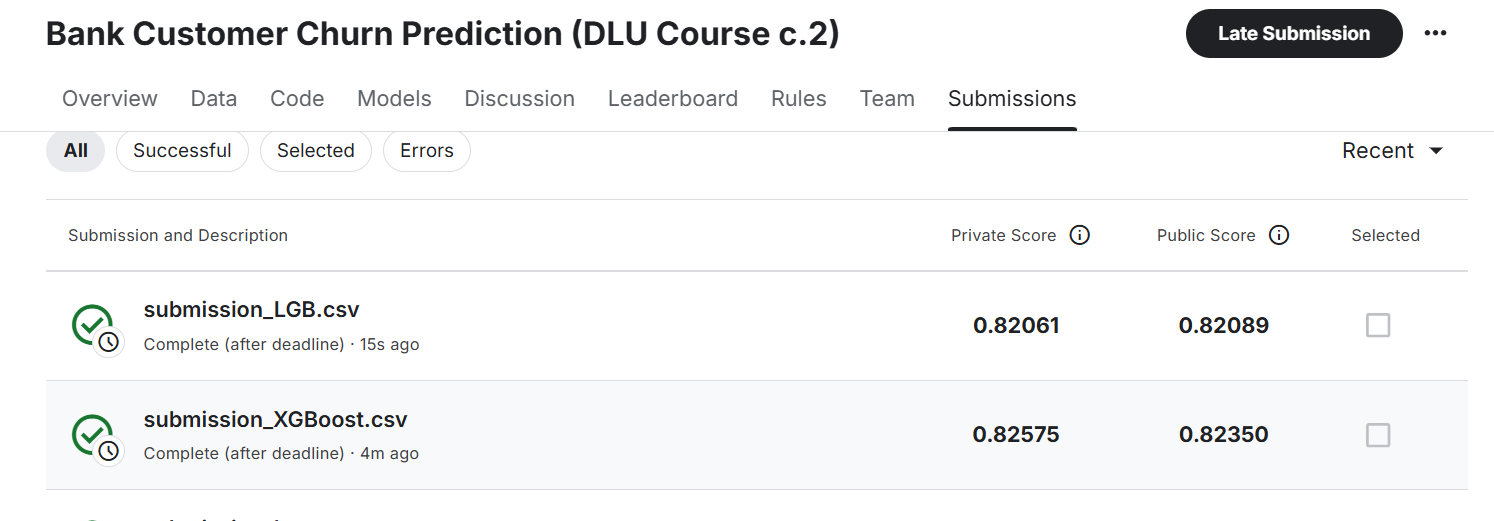